# Concept Mapping of Ontologies


## Data Sources

### Corpus

The [corpus](https://www.constitutueproject.org) comprises the set of in-force national constitutions compiled by the CCP. Each constitution contain a number of sections (referred to as segments).

### Ontologies

- CCP-FACET: A faceted version of the [CCP ontology](https://www.constitutueproject.org).
- FJC-IDB: Concatenated Federal Judicial Center databases:
    - [Federal Judicial Center,Appeals Integrated Database](https://www.fjc.gov/sites/default/files/idb/codebooks/Appeals%20Codebook%201971-2007.pdf)
    - [Federal Judicial Center,Bankruptcy Petition Newstats Snapshots Database](https://www.fjc.gov/sites/default/files/idb/codebooks/Bankruptcy%20IDB%20Online%20Codebook%20rev%2002282023.pdf)
    - [Federal Judicial Center,Civil Integrated Database](https://www.fjc.gov/sites/default/files/idb/codebooks/Civil%20Codebook%201970-1987.pdf)
    - [Federal Judicial Center,Criminal Integrated Database](https://www.fjc.gov/sites/default/files/idb/codebooks/Criminal%20Code%20Book%201970-1995.pdf)
- GLOBALCIT-GLO: [Global Citizenship Observatory, Glossary on Citizenship and Electoral Rights](https://globalcit.eu/glossary)
- IDEA-DT: [International IDEA Democracy Tracker](https://www.idea.int/publications/catalogue/html/democracy-tracker-methodology-and-user-guide-version-2-february-2025)
- IDEA-GLO: [International IDEA Database Glossary](https://www.idea.int/data-tools)
- JUON-CPSD: [Andreas Juon,Constitutional Power-Sharing Dataset](https://doi.org/10.7910/DVN/9FYN8J)
- STROM-IDC: [Scott Gates, Benjamin A. T. Graham, and Håvard Strand, Inclusion, Dispersion, and Constraint Dataset](https://doi.org/10.7910/DVN/29421)

The ontology label is the identifier in upper case letters, e.g., CCP-FACET.

All ontologies were formatted to conform to the Sartori Network's ontology specification of:

- One topic per row
- A minimum column set comprising the following fields:
    - key: a short topic identifier. If this is not provided by the ontology owner, then an integer is used.
    - label: a short human-readable text label.
    - description: a longer descriptive text.
- A first row containing the column names: `Key`, `Label`, `Description`.


## Rationale

The methodology examines the semantic similarities between topics in a set of ontologies and sections (referred to as segments) of the corpus of national constitutions.

Topics that are similar to a given segment are regarded as coding the meaning of the segment. If the set of topics similar to a segment belong to more than one ontology, then the ontologies are aligned conceptually and we have discovered a conceptual mapping between ontologies.


## Methodology

The methodology is based on processing of semantic similarity matrices constructed during ontology and corpus processing — see the codebase in the `processing` folder. The similarity matrices can be found in the `model` folder in the following files:

- CCP-FACET_topic_segment_matrix.json
- FJC-IDB_topic_segment_matrix.json
- GLOBALCIT-GLO_topic_segment_matrix.json
- IDEA-DT_topic_segment_matrix.json
- IDEA-GLO_topic_segment_matrix.json
- JUON-CPSD_topic_segment_matrix.json
- STROM-IDC_topic_segment_matrix.json

Each matrix has the topics of the ontology in rows, and the segments of the corpus in columns. Cells contain the semantic similarity score of a topic-segment pair. Similarity scores are calculated as the angular distance between the encoding vectors of topic and segment text where the topic text is the concatenated label and description. Encoding vectors were generating using Google's Universal Sentence Encoder version 4.


### Process

For each ontology-segment matrix:

1. Threshold and binarise the matrix.
2. Compute the column marginal of each binarised matrix.
3. Use the column marginals to create an ontology-segment matrix with ontology column marginals in rows and segments in columns.

The figure below illustrates steps 2 and 3.

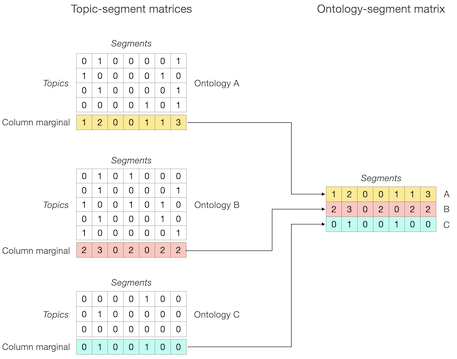

We can now query the ontology-segment matrix. Logical operations include locating segments that are semantically similar to some combination of ontologies. We can also locate segments similar to some number of ontologies without specifying which ontologies.

## Interpretation

The figure above illustrates the types of patterns that are found in the columns (therefore text segments) of the ontology-segment matrix. Moving left to right across the columns we have:

- Column 1: Ontologies A and B both contain topics that are similar to the text segment in column 1. Ontology A contains one similar topic, B contains two similar topics.
- Column 2: All three ontologies contain topics similar to the segment in column 2. The number of similar topics is different for each ontology.
- Column 3: None of the three ontologies contain topics similar to the segment in column 3.
- Column 4: Only ontology B contains topics (two in total) similar to the segment in column 4.
- Column 5: Ontology A and C each contain one topic similar to the segment in column 5.
- Column 6: Ontology A contains one topic similar to the segment, ontology B two.
- Column 7: Ontology A contains three topics similar to the segment, ontology B two.

Each segment can be represented and visualised as a star graph, i.e., a complete bipartite graph with one central vertex and a set of leaf vertices. The leaf vertices set may be an empty set (column 3), or a set of vertices comprising topics from one or more of the ontologies.


## Initialialisation

### Load code and model

In [ ]:
__author__      = 'Roy Gardner'
__copyright__   = 'Copyright 2025, Roy and Sally Gardner'

%run ./_library/packages.py
%run ./_library/utilities.py
%run ./_library/comparison.py


In [ ]:
model_path = '../model/'

exclusion_list = []
_,_,files = next(os.walk(model_path))
for file in files:
    if '_encodings.json' in file:
        exclusion_list.append(file)

model_dict = initialise(model_path,exclusion_list=exclusion_list)


## Build the ontology-segment matrix

### Step 1: Set the semantic similarity threshold

Run the cell below to generate the interface within which you set the semantic similarity threshold for matching ontology topics to constitution sections.

If you find there are too many results when you run concept mapping below, then return to this interface and select a higher threshold. If you find too few results when you run concept mapping below then select a lower threshold.

Once you are happy with your choice click on the `Apply` button and move on to Step 2.


In [ ]:
mapping_threshold_choice_dict = init_mapping_threshold_choice_dict()
mapping_threshold_interface(mapping_threshold_choice_dict,0.70)


### Step 2: Build the ontology-segment matrix using the threshold value

This step builds a thresholded topic-segment matrix for each ontology followed by the ontology-segment matrix. These matrices are illustrated in the figure above.


In [ ]:
threshold = mapping_threshold_choice_dict['threshold']

ont_count = len(model_dict['ontologies_dict'])
ont_labels = sorted(list(model_dict['ontologies_dict'].keys()))

matrix_dict = {} # This stores our thresholded matrices
ont_segment_matrix = []

for ont_label in ont_labels:
    print(f'Processing ontology:{ont_label}')
    ont_matrix = np.array(model_dict[f'{ont_label}_topic_segment_matrix'])
    
    M = np.where(ont_matrix>=threshold,1,0).astype(int)
    marginal = np.sum(M,axis=0)
    ont_segment_matrix.append(marginal)
    matrix_dict[ont_label] = M

ont_segment_matrix = np.array(ont_segment_matrix)

print('Finished')

    

## Ontology-ontology co-occurrence in segment space

The heatmap shows the number of corpus segments that a pair of ontologies have in common. This overview provides a guide for selecting ontologies in the cells below.

In [ ]:
# Binarise the ontology-segment matrix because we want segments counts
# in the cells of the co-occurrence matrix
bin_matrix = (ont_segment_matrix>0).astype(int)
ont_coo = np.triu(np.matmul(bin_matrix,bin_matrix.T),k=1)

fig, ax = plt.subplots()
im = ax.imshow(ont_coo, cmap='Blues')
plt.yticks(range(len(ont_labels)),ont_labels)
plt.xticks(range(len(ont_labels)),ont_labels,rotation=90)

# Add text annotations
for i in range(ont_coo.shape[0]):
    for j in range(ont_coo.shape[1]):
        value = ont_coo[i, j]
        if j <= i:
            continue
        if value < 400:
            color = 'black'
        else:
            color = 'white'
        text = ax.text(j,i,value,ha="center", va="center", color=color)

plt.show()

## Concept mapping using selected ontologies

### Step 1: Create a query

Run the cell below to generate the interface within which you select two or more ontologies. The ontology-segment matrix is used to find segments that are similar to topics in all of the selected ontologies.

Once you are happy with your choices click on the `Apply` button and move on to Step 2.


In [ ]:

query_choice_dict = init_query_choice_dict()
query_interface(query_choice_dict,model_dict)


### Step 2: Run the query and view results

In this step, we find and list constitution sections that are semantically similar to topics in each of the ontologies selected above.

Sections and the topics that are similar to a section appears in a set of HTML table below. Each table has the following structure:

- A header with a pink background containing the section ID and text.The section ID is a link to the section in the [Constitute Project](https://www.constituteproject.org/) website. By using this link you are able to vew the section in the context of the consitution to which it belongs.
- A set of rows for each topics containing:
    - The label of the topic's ontology.
    - The topic's key.
    - The topic's label.
    - The topic's description.
    
The number of results depends upon the ontologies selected and the threshold value set in `Build the ontology-segment matrix Step 1` above. For example, if you select too many ontologies, then the liklihood of the ontologies all having topics that are similar to constitution section decreases. Reducing the threshold in `Build the ontology-segment matrix Step 1` and re-running your ontology selection will fix this but at the cost of reducing the precision of semantic matches.


In [ ]:

if len(query_choice_dict['choices']) >= 2:

    # Get a query class instance
    q = MatrixColumnQuery(ont_segment_matrix)
    # Run the qnuery
    results = q.all_positions_nonzero(query_choice_dict['choices'])
    if len(results) > 0:
        list_query_results(results,ont_segment_matrix,matrix_dict,model_dict)
    else:
        print(f"There are no segments similar to topics from the selected ontologies.")
        print('Try a lower threshold setting or selecting another set of ontologies.')    

else:
    print('Please select at least two ontologies in the interface above.')




## Concept mapping using number of ontologies

### Step 1: Create a query

Run the cell below to generate the interface within which you select an ontology count. You are asking the application to find constitution sections that are similar to topics from at least the number of ontologies you selected, or exactly the number of ontologies you selected.

Use the slider to set the number of ontologies and the checkbox to set whether you require an exact match to the number of ontologies. If the checkbox is unchecked the number of ontologies you select is the minimum number rather than the exact number.

Step 2 below will find constitution sections that are semantically similar to topics from the number of ontologies you have selected.

Once you are happy with your choices click on the `Apply` button and move on to Step 2.


In [ ]:

ont_count_dict = init_ont_count_dict()
ont_count_interface(ont_count_dict,model_dict)


### Step 2: Run the query and view results

In this step, we find and list constitution sections that are semantically similar to topics from at least or exactly the number of ontologies you selected.

Sections and the topics that are similar to a section appears in a set of HTML table below. Each table has the following structure:

- A header with a pink background containing the section ID and text.The section ID is a link to the section in the [Constitute Project](https://www.constituteproject.org/) website. By using this link you are able to vew the section in the context of the consitution to which it belongs.
- A set of rows for each topics containing:
    - The label of the topic's ontology.
    - The topic's key.
    - The topic's label.
    - The topic's description.

The number of results depends upon the number ontologies selected and the threshold value set in `Build the ontology-segment matrix Step 1`. For example, if you select too many ontologies and impose exact matching, then the liklihood of finding that number of ontologies all having topics that are similar to constitution section decreases. Reducing the threshold in `Build the ontology-segment matrix Step 1` and re-running your ontology selection will fix this but at the cost of reducing the precision of semantic matches.


In [ ]:

# Get a query class instance
q = MatrixColumnQuery(ont_segment_matrix)

# Run the query
if ont_count_dict['exact']:
    results = q.count_nonzero(ont_count_dict['count'])
else:
    results = q.count_min_nonzero(ont_count_dict['count'])
    
if len(results) > 0:
    list_query_results(results,ont_segment_matrix,matrix_dict,model_dict)
else:
    print(f"There are no segments similar to topics from {ont_count_dict['count']} ontologies.")
    print('Try a lower threshold setting or reduce the number of ontologies.')
